In [2]:
library(randomForest)
library(extraTrees)
library(cluster)
library(boot)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loading required package: rJava


# Unsupervised Random Forest : test on dummy data


## Variables utilisées : 

In [3]:
nb_var = 500 #Nombre de variables
nb_obs = 200 #Nombre d'observations
nb_bruit = 50 #Nombre de variables de bruit
K = 3 #Nombre de clusters
sd = 2 #Standard deviation des clusters gaussiens
sparsity = 60/100 # Sparsité naïve : pourcentage de 0 ajoutés aléatoirement dans les données
struct_sparsity = 40/100 #Sparsité structurée : les zéros sont mis dans les mêmes colonnes au sein d'un même cluster


nb_forests = 5
nb_trees = 800
mtry = as.integer(sqrt(nb_var))

## Génération des données : 

In [4]:
#Clusters alignés (dépendance linaire)
Gen_Clust_dat_1 = function(K, nb_var, nb_obs){ #On génère des données dans des clusters gaussien
    #On crée les centre des clusters
    clust_centers = data.frame()
    for (i in 1:K){
        clust_centers = rbind(clust_centers, numeric(nb_var) + i*5*sd + runif(nb_var, -3, 3))
    }
    #On génère les clusters : les centres sont tous sur la droite y = x et ecartés des 5 écarts types
    Data = data.frame()
    clust_index = data.frame()
    for (i in 1:(nb_obs)){
        clust_index = rbind(clust_index, sample(1:K, 1))
        Data = rbind(Data, rnorm(nb_var, mean = as.numeric(clust_centers[clust_index[i,1],]) ) )
    }
    return (list(Data, clust_index))
}

#Clusters placés aléatoirements dans l'espace 
Gen_Clust_dat_2 = function(K, nb_var, nb_obs){
    clust_centers_center = K*(numeric(nb_var)+20*sd)
    clust_centers = data.frame()
    for (i in 1:K){
        clust_centers = rbind(clust_centers, rnorm(nb_var, mean = clust_centers_center, sd = K*8*sd ))
    }
    
    Data = data.frame()
    clust_index = data.frame()
    for (i in 1:(nb_obs)){
        clust_index = rbind(clust_index, sample(1:K, 1))
        Data = rbind(Data, rnorm(nb_var, mean = as.numeric(clust_centers[clust_index[i,1],]) ) )
    }
    return (list(Data, clust_index))
}


#Sparsity (naïve, casse les clusters) Rend la matrice sparse d'un pourcentage égal à sparsity en mettant des zeros au hasard
make_sparse = function(dat, sparsity){
    dat2 = as.matrix(dat)
    nrow = dim(dat)[1] ; ncol = dim(dat)[2]
    dat2[sample(1:(ncol*nrow), as.integer(sparsity*ncol*nrow))] = 0
    return(data.frame(dat2))
}

#Sparsity structurée (selon certaines variables)
structured_sparsity = function(Data, K, struct_sparsity, clust_index){
    zeros_var = data.frame()
    for (i in 1:K){ #On choisit pour chaque cluster quels variables seront annulées
        zeros_var = rbind(zeros_var, sample(1:nb_var, as.integer(struct_sparsity*nb_var)))
    }
    
    for (i in 1:nb_obs){#Sur chaque ligne on annule les variables qui doivent être annulées pour ce cluster
        Data[ i, as.double( zeros_var[clust_index[i,],] ) ] = 0
    }
    return(Data)
}

#Bruitage : on ajout nb_bruits uniforme sur un hyper-rectangle qui englobe les données. 
bruitage = function(Data, nb_bruit){
    for (i in 1:nb_bruit){
        Data = cbind(Data, runif(nb_obs, 0, K*5*sd +5*sd))
    }
    return(Data)
}

# Choisir paramètres de génération ici : 

In [5]:
temp = Gen_Clust_dat_2(K, nb_var-nb_bruit, nb_obs)
Data = data.frame(temp[1])
clust_index = data.frame(temp[2])

if (nb_bruit != 0) { Data = bruitage(Data, nb_bruit) }

Data = make_sparse(Data, sparsity) #Sparsité naïve
# Data = structured_sparsity(Data, K, struct_sparsity, clust_index) #Sparsité structurée

In [6]:
#On renomme les variable de signal Xi et variable de bruit Yi
for (i in 1:nb_var - nb_bruit){
    colnames(Data)[i] = paste("X", toString(i), sep='')
}

if (nb_bruit != 0){
    for (i in 1:nb_bruit){
        colnames(Data)[i + nb_var - nb_bruit] = paste("Y", toString(i), sep='')
    }
}
# #Rescaling des données sur [0,1]
# rescale = function(X) { (X - min(X))/(max(X) - min(X)) }
# Data = data.frame(apply(Data, 2, rescale))

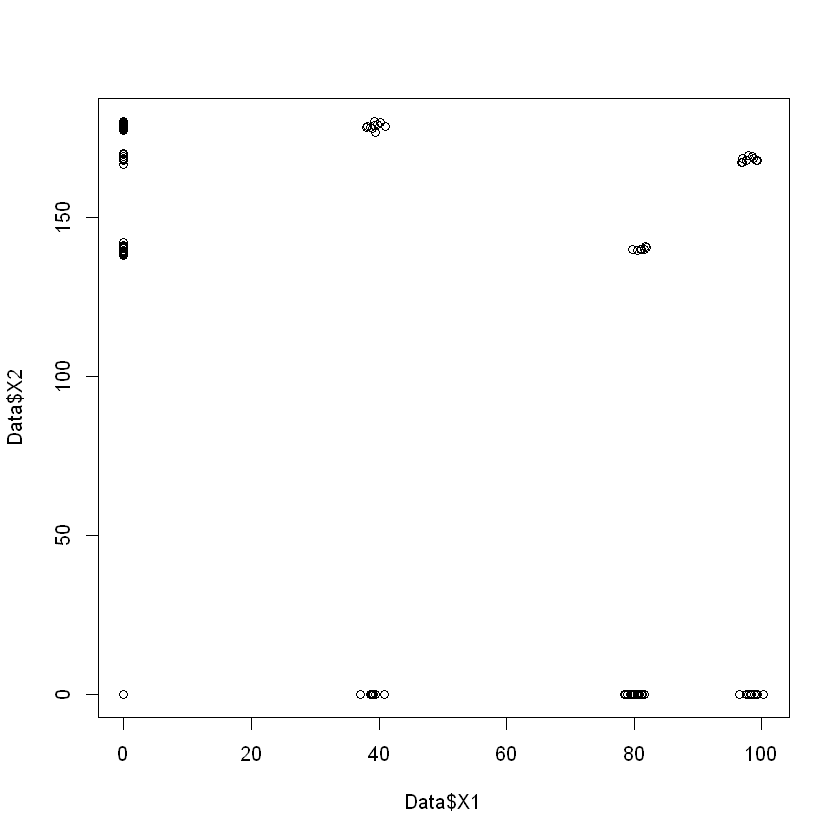

In [7]:
plot(Data$X1, Data$X2)

## Addcl1

On crée un jeu de données synthétiques en effectuant un Bootstrap des observations de notre matrice d'expression de gènes. Ce jeu de données nous servira pour transformée le problème d'apprentissage non supervisé en problème supervisé.

On crée deux classes arbitraires en rangeant nos données "réelles" dans l'une et nos données synthetiques dans l'autre. On va fit notre RF sur cette classification pour lui faire discerner les structures de dépendances entre les gènes.

In [8]:
addcl1 = function(dat) {
        bootstrap = function(X)   { sample(X, replace=T) } 
        col_bootstrap = function(dat) { apply(dat,2, bootstrap) } #On bootstrap sur chaque colonne
        nrow <- dim(dat)[1];
        Classe <- rep(c(1,2),c(nrow,nrow) ); #Un vecteur contenant nb_obs 1 et nb_obs 2, les classes sur lesquelles la URF va travailler
        data.frame(cbind(Classe,rbind(dat,data.frame(col_bootstrap(dat)))))
    }

## VarImpPlot pour multi-forets
Adaptation du code source de VarImpPlot sur cette page pour le cas multi-forets (https://github.com/cran/randomForest/blob/master/R/varImpPlot.R)

In [18]:
varImpPlot_mult = function(imp, sort=TRUE,
                       n.var=min(30, nrow(imp)),
                       main=deparse(substitute(x)), ...) {
    if (ncol(imp) > 2) imp <- imp[, -(1:(ncol(imp) - 2))]
    nmeas = ncol(imp)
    if (nmeas > 1) {
        op = par(mfrow=c(1, 2), mar=c(4, 5, 4, 1), mgp=c(2, .8, 0),
                  oma=c(0, 0, 2, 0), no.readonly=TRUE)
        on.exit(par(op))
    }
    for (i in 1:nmeas) {
        ord <- if (sort) rev(order(imp[,i],
                                   decreasing=TRUE)[1:n.var]) else 1:n.var
        xmin <- if (colnames(imp)[i] %in%
                    c("IncNodePurity", "MeanDecreaseGini")) 0 else min(imp[ord, i])
        dotchart(imp[ord,i], xlab=colnames(imp)[i], ylab="",
                 main=if (nmeas == 1) main else NULL,
                 xlim=c(xmin, max(imp[,i])), ...)
    }
    if (nmeas > 1) mtext(outer=TRUE, side=3, text=main, cex=1.2)
    invisible(imp)
}



<br><br><br><br>

# Random forest avec Addcl1 "homemade" :

In [10]:
RFproxTotal = matrix(0, nb_obs, nb_obs)
RFimportance = matrix(0, nrow=nb_var, ncol=4)
for (i in 1:nb_forests){
    DataRFsyn = addcl1(Data)
    target = DataRFsyn[,1]
    RF = randomForest(factor(target)~.,data=DataRFsyn[,-1], ntree=nb_trees, proximity=TRUE, mtry=mtry, importance=TRUE) 
    RF$prox = RF$prox[1:nb_obs, 1:nb_obs]
    RFproxTotal = RFproxTotal + RF$prox
    RFimportance = RFimportance + (1/nb_forests)*(RF$importance)
}
RFproxTotal = RFproxTotal/nb_forests



Call:
 randomForest(formula = factor(target) ~ ., data = DataRFsyn[,      -1], ntree = nb_trees, proximity = TRUE, mtry = mtry, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 800
No. of variables tried at each split: 22

        OOB estimate of  error rate: 16.75%
Confusion matrix:
    1   2 class.error
1 181  19       0.095
2  48 152       0.240

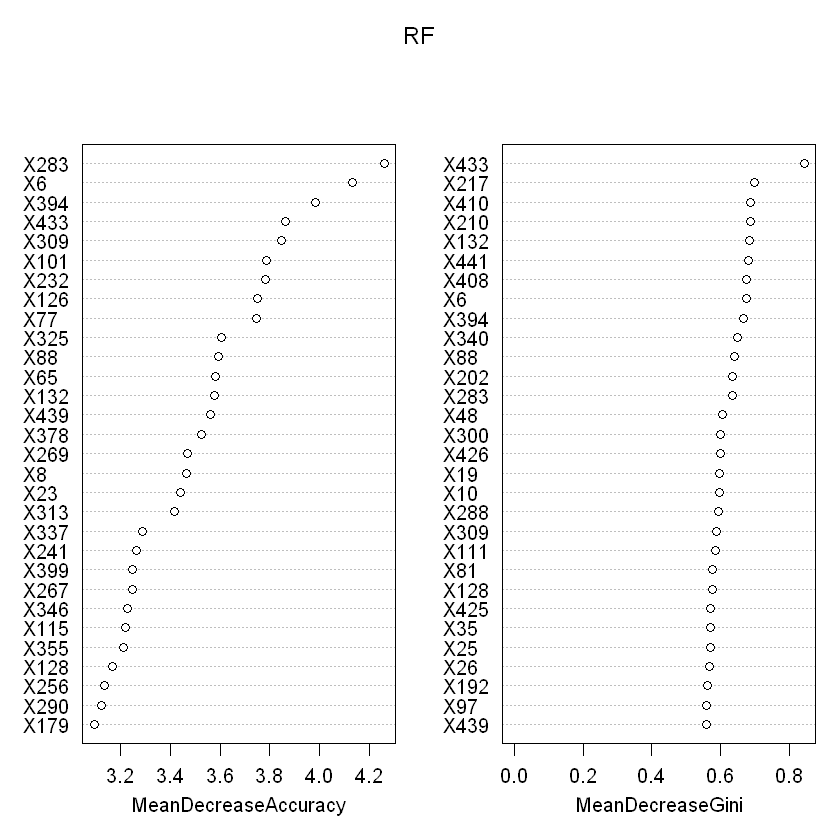

In [19]:
RF
varImpPlot_mult(RFimportance)

<br><br><br><br>
## On réessaie en utilisant la fonction de sampling Addcl1 de CranR


Call:
 randomForest(x = Data, ntree = 500, mtry = mtry, importance = TRUE,      proximity = TRUE, addclass = 1) 
               Type of random forest: unsupervised
                     Number of trees: 500
No. of variables tried at each split: 22


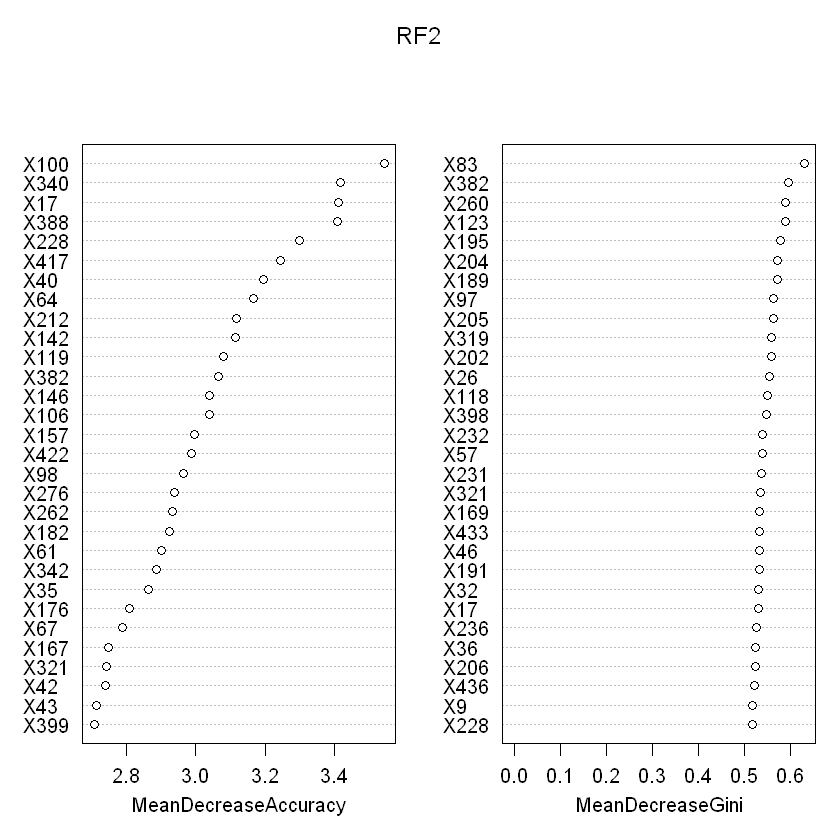

In [12]:
RF2 = randomForest(Data,
                    mtry=mtry, 
                    ntree = 500, 
                    addclass = 1,
                    importance = TRUE,
                    proximity = TRUE)
RF2
varImpPlot(RF2)
            

# MDS
## Addcl1 "homemade"

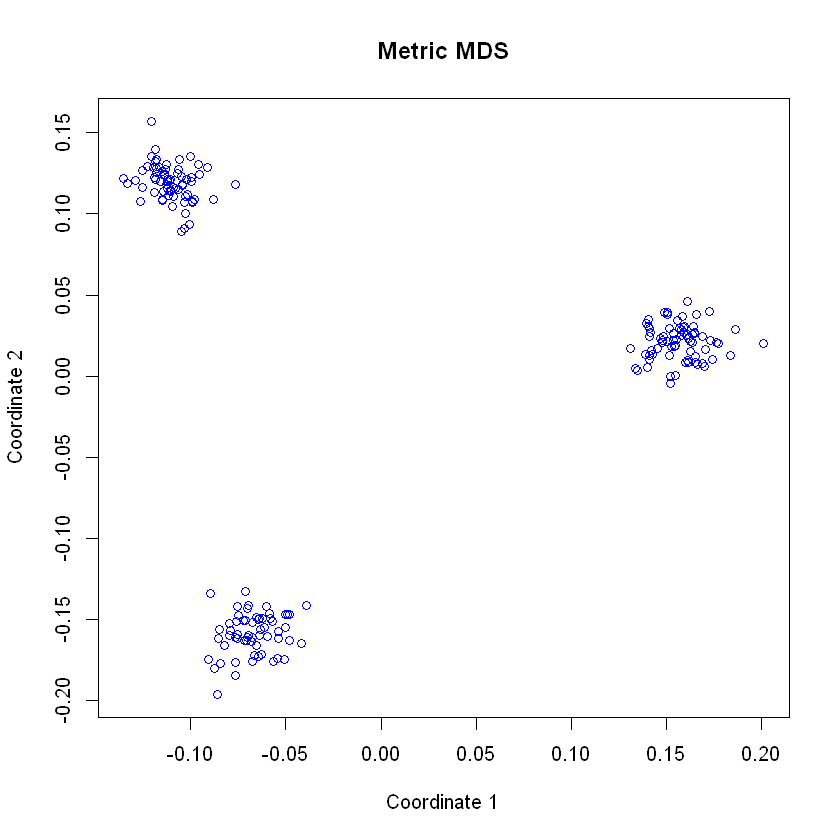

In [13]:
DISS = sqrt(1-RFproxTotal) #la matrice de dissimilarité de la random forest
MDS = cmdscale(DISS,eig=TRUE, k=2)
x <- MDS$points[,1]
y <- MDS$points[,2]
plot(x, y, xlab="Coordinate 1", ylab="Coordinate 2", 
  main="Metric MDS", col = "blue")

## Addcl1 CranR : 1 seule forêt

Warning message in RColorBrewer::brewer.pal(nlevs, "Set1"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

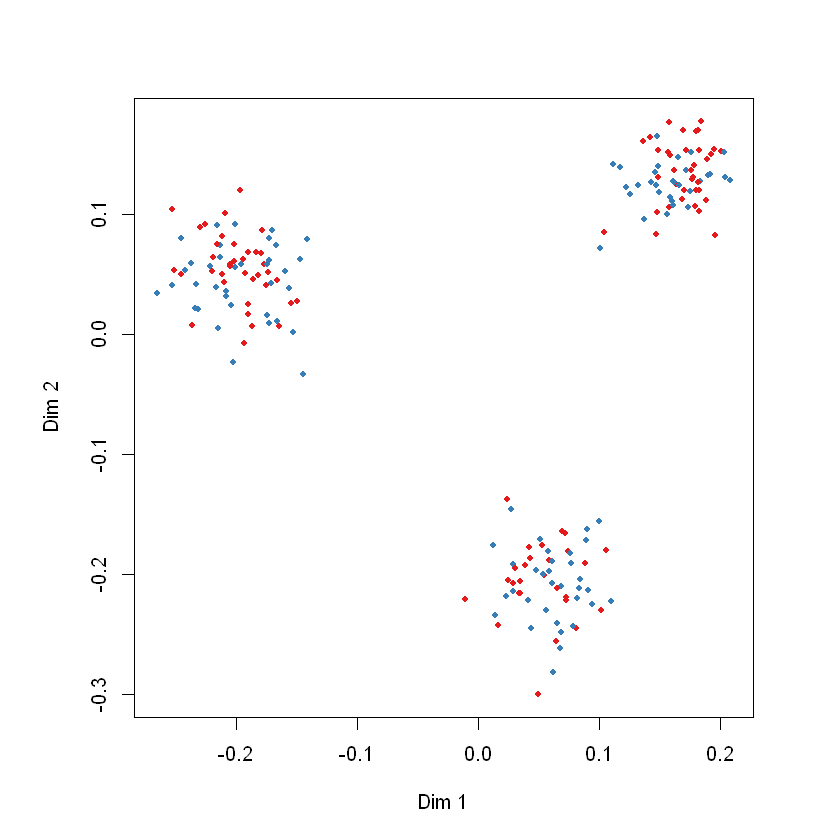

In [14]:
MDSplot(RF2, RF2$classe)

<br><br><br><br>

# ExtraTrees

In [15]:
mtry_ext = as.integer(sqrt(nb_var))
n_copies = 5

## Addcl3 : On labelle toute nos données au hasard sur deux classes. (Magie?)

In [16]:
addcl3 = function(dat) {
    nrow <- dim(dat)[1]
    Classe = numeric(nrow)
    sample1 = sample(1:nrow, as.integer(nrow/2))
    Classe[sample1] = 1;
    Classe[-sample1] = 2
    dat = cbind(Classe, dat)
    }

## TODO: Coder matrice de proximité pour extraTrees